<a href="https://colab.research.google.com/github/coimbra574/Ciencias-de-Dados/blob/main/EDA_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importando dados

In [ ]:
df_students = pd.read_csv('/content/drive/MyDrive/Aulas Americanas/Modulo III - Técnicas de Programação/StudentsPerformance.csv')
df_students.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Avaliando dados faltantes

In [ ]:
# Nenhum dado faltante
df_students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Avaliando dados duplicados

In [ ]:
# Não há dados duplicados
df_students[df_students.duplicated()]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score


In [ ]:
# Verificando atributos constantes
for col in df_students.columns:
    print(f'{col} = {df_students[col].nunique()}')

gender = 2
race/ethnicity = 5
parental level of education = 6
lunch = 2
test preparation course = 2
math score = 81
reading score = 72
writing score = 77


## Pré-processamento

In [ ]:
# Mudar nome das colunas para facilitar codigo
df_students = df_students.rename(columns={'race/ethnicity': 'race', 'parental level of education' : 'parents_education',
                                            'test preparation course': 'preparation', 'math score' : 'math_score', 
                                            'reading score' : 'reading_score', 'writing score' :  'writing_score'})

In [ ]:
# Transformar dados categóricos para valores numericos
df_students['gender'] = np.where(df_students['gender'] == 'male', 1,0)
df_students['preparation'] = np.where(df_students['preparation'] == 'completed', 1,0)
df_students['lunch'] = np.where(df_students['lunch'] == 'standard', 1,0)

df_students['race'] = df_students['race'].map({'group A' : 0, 'group B' : 1, 'group C' : 2, 'group D' : 3, 'group E' : 4})

df_students['parents_education'] = df_students['parents_education'].map({'some high school' : 0, 'high school' : 1, 
                                                                         'associate\'s degree' : 2, 'some college' : 3, 
                                                                        'bachelor\'s degree' : 4, 'master\'s degree' : 5})



## Análise Exploratória

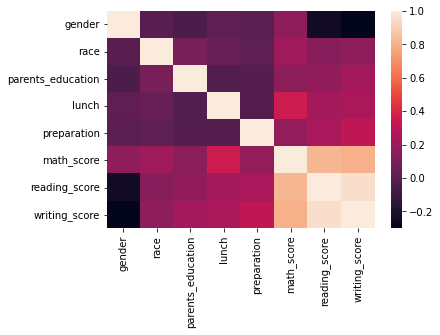

In [ ]:
# Verificando a correlação dos dados
corr = df_students.corr('pearson')
sns.heatmap(corr)

Pelo mapa de calor parece que quem tira nota alta ou baixa em uma das matérias, tende a manter essa performance para as outras matérias também.

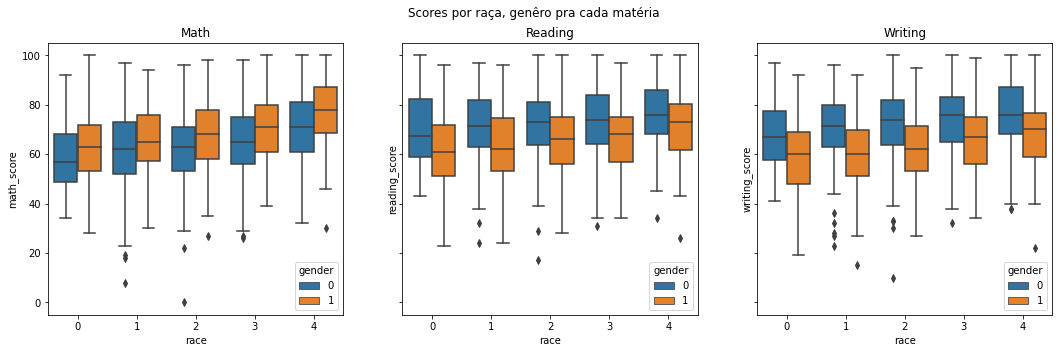

In [ ]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(18,5))
fig.suptitle('Scores por raça, genêro pra cada matéria')

materias = ['math_score', 'reading_score',  'writing_score']

for idx, materia in enumerate(materias):
    sns.boxplot(ax=axes[idx], x ='race', y = materia, hue = 'gender', data = df_students)
    axes[idx].set_title(materia.split('_')[0].title())

In [ ]:
teste = 'math_score'
teste.split('_')[0]

'math'

Para leitura e escrita mulheres tem em média um score maior, enquanto que homens se sobressaem em matemática. Além disso, a etnia A parece ter notas ligeiramente inferiores em média, e a etnia E maiores notas em média.

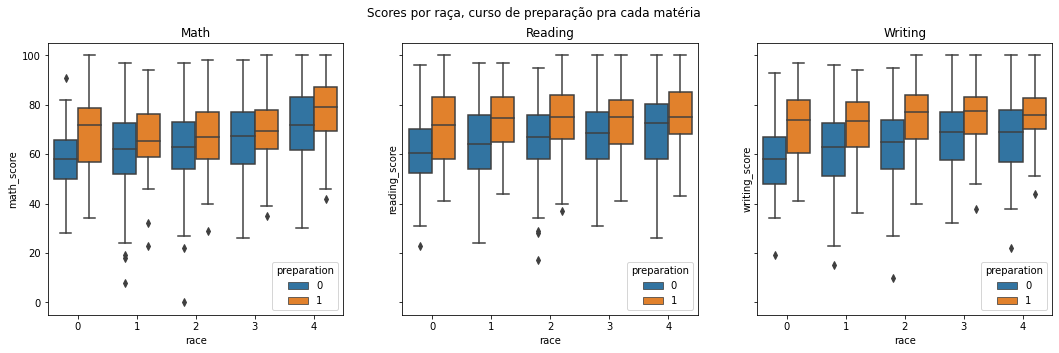

In [ ]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(18,5))
fig.suptitle('Scores por raça, curso de preparação pra cada matéria')

materias = ['math_score', 'reading_score',  'writing_score']

for idx, materia in enumerate(materias):
    sns.boxplot(ax=axes[idx], x ='race', y = materia, hue = 'preparation', data = df_students)
    axes[idx].set_title(materia.split('_')[0].title())

Com o curso de preparação as notas melhoraram significativamente, em especial para a etnia A, mostrando talvez um desfalque na educação destes alunos que foi preenchida pelo curso preparatório. 


<br>

Pode ter acontecido também de não haver dados suficientes, e poucos alunos tiveram bons resultados, não representando a média real daquele grupo. Testando essa hipótese:

In [ ]:
# Verificando se temos dados suficientes em cada etnia para análise
df_students['race'].value_counts()

2    319
3    262
1    190
4    140
0     89
Name: race, dtype: int64

In [ ]:
# De 89 alunos da classe A, 31 fizeram o curso preparatório. 
mask_race_0 = df_students['race'] == 0
mask_prep_1 = df_students['preparation'] == 1
len(df_students.loc[mask_race_0 & mask_prep_1])

31

Não parece ser este o problema. O desfalque na educação pode ocorrer por diversos motivos, incluindo o poder aquisitivo médio da etnia. Como não temos dados sobre a média salarial dos pais, um indicativo pode ser a escolaridade deles, considerando que é proporcional também ao poder aquisitivo (apesar de nem sempre ser o caso). Testando:

Text(0.5, 1.05, 'Porcentagem do nível de escolaridade dos pais, por etnia')

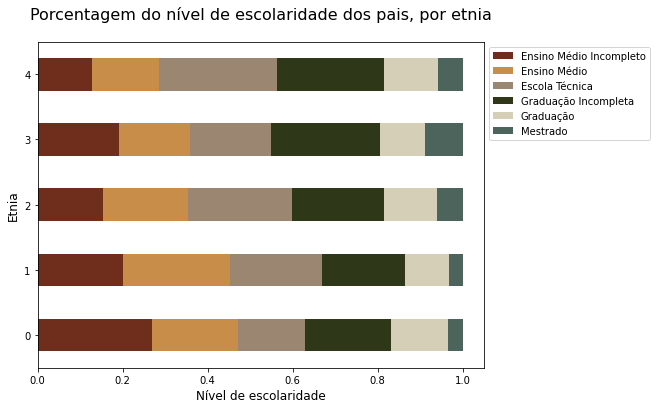

In [ ]:
# A função crosstab faz um groupby com base no index, separando as colunas especificadas 
# de acordo com seus labels utilizando uma função de agregação (default = sum()). O normalize computa
# a porcentagem
cross_tab = pd.crosstab(index=df_students['race'],
                             columns=df_students['parents_education'],
                             normalize="index").reset_index()

colors = ['#6F2E1C', '#C88D49', '#9B8672', '#2E3819', '#D5CFB7', '#4D645C']

cross_tab.plot.barh(x='race', stacked=True, figsize=(8,6), color=colors)
plt.legend(labels=['Ensino Médio Incompleto', 'Ensino Médio', 'Escola Técnica', 
                   'Graduação Incompleta', 'Graduação', 'Mestrado'], bbox_to_anchor=(1,1))

plt.xlabel('Nível de escolaridade', fontsize=12)
plt.ylabel('Etnia', fontsize=12)
plt.title('Porcentagem do nível de escolaridade dos pais, por etnia', size=16, y=1.05)


As etnias 0 e 1 foram as que obteram as notas mais baixas sem o curso preparatório, e a com maior percentual de pais com nível mais baixo de escolaridade (ensino médio e ensino médio incompleto) comparadas às outras etnias. 

<br>
<br>

Um ponto que chamou a atenção foi a correlação relativamente alta entre o tipo de almoço (standard ou free) e notas mais altas:


In [ ]:
df_students['mean_score'] = (df_students['math_score'] + df_students['reading_score'] + df_students['writing_score']) / 3

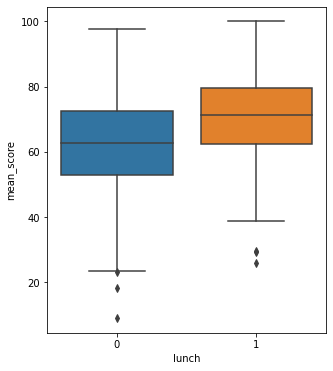

In [ ]:
plt.figure(figsize=(5,6))
sns.boxplot(x='lunch', y='mean_score', data=df_students)

Alunos com almoço standard obtiveram maiores notas em relação a alunos com almoço free/reduced (com desconto): pode ser mais um indicio da influencia do poder aquisitivo na vida escolar dos alunos

<br>
<br>

Avaliando o desempenho geral dos alunos, e se precisam melhorar em alguma matéria

Text(0.5, 0, 'Scores')

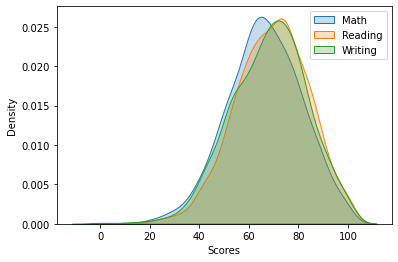

In [ ]:
sns.kdeplot(data=df_students, x='math_score', fill=True)
sns.kdeplot(data=df_students, x='reading_score', fill=True)
sns.kdeplot(data=df_students, x='writing_score', fill=True)
plt.legend(labels=['Math', 'Reading', 'Writing'])
plt.xlabel('Scores')


As notas de writing e reading estão distribuidas em torno de uma média de 70%, enquanto as notas de matematica parecem ser mais baixas em média.

In [ ]:
df_students[['math_score', 'writing_score', 'reading_score']].describe()

,math_score,writing_score,reading_score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,68.054000,69.169000
std,15.16308,15.195657,14.600192
min,0.00000,10.000000,17.000000
25%,57.00000,57.750000,59.000000
50%,66.00000,69.000000,70.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000
